<img src="https://drive.google.com/uc?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff" width="500"/>

---


# **Recap (1)**

#### **Morning contents/agenda**

1. Overview of contents covered

2. A design and training guide

3. Key network operations

4. U-Net

5. Backpropagation

<br>

#### **Afternoon contents/agenda**

1. Building a U-Net from scratch

<br/>

---

<br/>

In [1]:
!pip install pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 19.1 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1. Building a U-Net from scratch

Today, we're going to try to build our own U-Net and apply it to the problem we saw on Day03: denoising the ChestMNIST dataset.

Let's follow the steps we always follow:

1. Create a `Dataset` object(s) that will contain your complete dataset (either a custom one by creating a class that inherits from Dataset or one extracted directly from torch or torchvision).
2. Create a `Dataloader` object(s) to assemble batches from the Dataset and send them to the device. At this point, you might want to use a `StratifiedShuffleSplit` to separate between validation and training loaders.
3. Create a model, either by using a new `nn.Module` class or by downloading a predefined network like Alexnet.
4. Instantiate an appropriate criterion like MSE or CrossEntropy.
5. Instantiate an optimizer like SGD or Adam.
6. Create the train, validation, and test loops.
7. Run over all epochs using alternatively train and validation.
8. Run the test loop on the trained model.

<br>

Let's start by defining some hyperparameters for later:

In [3]:
set_seed(42)
p = 0.6
lr = 1e-3
batch_size = 128
num_workers = 0
wd = 1e-6
nepochs = 5

### **1.1. Create `Dataset` object(s)**

We can now download the dataset:

In [4]:
!wget https://zenodo.org/record/6496656/files/chestmnist.npz

--2025-12-01 12:35:13--  https://zenodo.org/record/6496656/files/chestmnist.npz
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.43.153, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/6496656/files/chestmnist.npz [following]
--2025-12-01 12:35:14--  https://zenodo.org/records/6496656/files/chestmnist.npz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 82802576 (79M) [application/octet-stream]
Saving to: ‘chestmnist.npz’

chestmnist.npz      100%[===================>]  78.97M  1.15MB/s    in 77s     

2025-12-01 12:36:33 (1.03 MB/s) - ‘chestmnist.npz’ saved [82802576/82802576]



In [5]:
data = np.load("./chestmnist.npz")

And create a custom `Dataset` to take care of adding noise to the images:

In [6]:
class ChestMNIST(Dataset):

    def __init__(self, data_path, split="train", p=0.5, transform=None):
        self.data_path = data_path
        self.p = p
        self.split = split
        self.transform = transform

        if split == "train":
            data = np.load(data_path)["train_images"]
        elif split == "validation":
            data = np.load(data_path)["val_images"]
        elif split == "test":
            data = np.load(data_path)["test_images"]
        else:
            raise ValueError("split parameter must be 'train', 'validation', or 'test'")

        self.data = torch.from_numpy(data).unsqueeze(1) #  tranform to torch add channel dimension

    def _get_mask(self, img_shape):
        c, w, h = img_shape
        masked_points = int((1 - self.p) * w * h)
        masked_idx = torch.randint(0, w * h, (masked_points,))
        mask = torch.ones((w * h))
        mask[masked_idx] = 0
        mask = mask.view(1, w, h)
        mask.repeat(c, 1, 1)
        return mask

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Apply transforms
        if self.transform:
            sample = self.transform(sample)

        # Masked data
        mask = self._get_mask(sample.shape)
        masked_sample = sample * mask

        return masked_sample, sample

    def __len__(self):
        return len(self.data)

In [7]:
tf = transforms.Compose([
    transforms.Lambda(lambda x:  x / 255.), # convert to a tensor and normalize to [0,1]
])

train_dataset = ChestMNIST("./chestmnist.npz", split="train", p=p, transform=tf)
valid_dataset = ChestMNIST("./chestmnist.npz", split="validation", p=p, transform=tf)
test_dataset = ChestMNIST("./chestmnist.npz", split="test", p=p, transform=tf)

### **1.2. Create a `Dataloader` object(s)**

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Let's test the `Dataset` and `DataLoader`:

torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28])


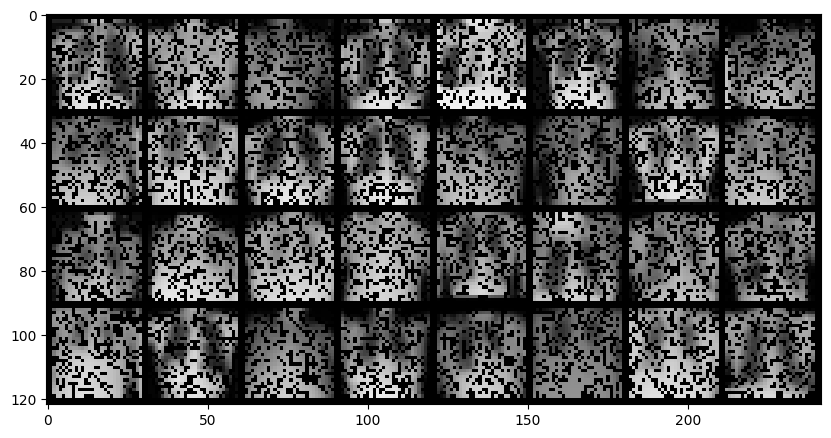

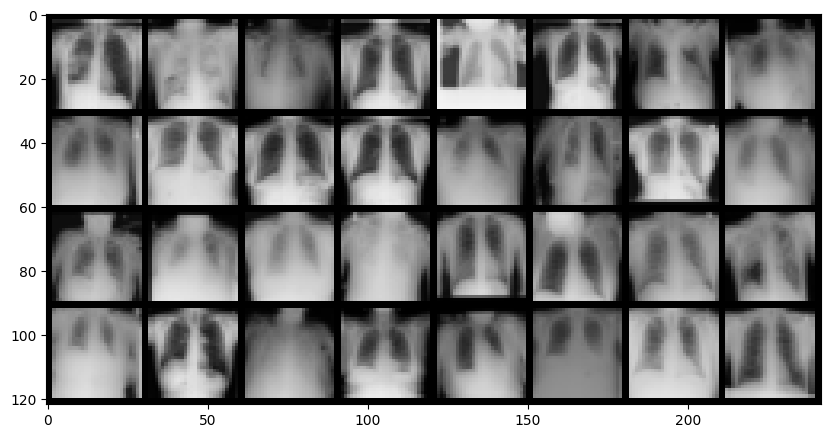

In [9]:
input, target = next(iter(train_loader))
input, target = input[:32], target[:32]

print(input.shape, target.shape)

input_grid = make_grid(input)
target_grid = make_grid(target)

plt.figure(figsize=(10,10))
plt.imshow(input_grid.detach().cpu().permute(1,2,0))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(target_grid.detach().cpu().permute(1,2,0))
plt.show()

### **1.3. Create a model**

In [10]:
# define a convolutional block with time-embedding
class ConvBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

# define an encoder block of the U-Net with time-embedding
class EncBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv_block1 = ConvBlock(in_c, out_c)
        self.conv_block2 = ConvBlock(out_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        h = self.conv_block1(x)
        h = self.conv_block2(h)
        p = self.pool(h)
        return h, p

# define an decoder block of the U-Net with time-embedding
class DecBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(2*out_c, out_c)
        self.conv_block2 = ConvBlock(out_c, out_c)

    def forward(self, x, s):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h)
        h = self.conv_block2(h)
        return h

In [11]:
class Unet(nn.Module):

    def __init__(self, n_channels):
        super().__init__()

        # encoder
        self.e1 = EncBlock(n_channels, 64)

        # bottleneck
        self.b1 = ConvBlock(64, 128)

        # decoder
        self.d4 = DecBlock(128, 64)

        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x):

        # encoder
        s1, x = self.e1(x)

        # bottleneck
        x = self.b1(x)

        # decoder
        x = self.d4(x, s1)

        # output
        output = self.output(x)

        return output

model = Unet(n_channels=1).to(device)

# Test model
output = model(torch.ones(1, 1, 28, 28).to(device))
print(output.shape)

# Print model
summ = summary(model, input_size=(1, 28, 28))

torch.Size([1, 1, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              SiLU-3           [-1, 64, 28, 28]               0
         ConvBlock-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              SiLU-7           [-1, 64, 28, 28]               0
         ConvBlock-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
         EncBlock-10  [[-1, 64, 28, 28], [-1, 64, 14, 14]]               0
           Conv2d-11          [-1, 128, 14, 14]          73,856
      BatchNorm2d-12          [-1, 128, 14, 14]             256
             SiLU-13          [-1, 128, 14, 14]               0
 

### **1.4. Instantiate an appropriate criterion like MSE or CrossEntropy**

In [12]:
mseloss = nn.MSELoss()

### **1.5. Instantiate an optimizer**

In [13]:
optimiser = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)

### **1.6. Create the train, validation, and test loops**

In [14]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss*input.size(0)
        optimizer.step()
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = criterion(output, target)
            valid_loss += loss*input.size(0)
        valid_loss = valid_loss / len(data_loader.dataset)
        return valid_loss


def test(model, data_loader):
    model.eval()
    targets = []
    outputs = []
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            targets.append(target)
            outputs.append(output)
        return torch.cat(targets), torch.cat(outputs)

### **1.7. Run over all epochs**

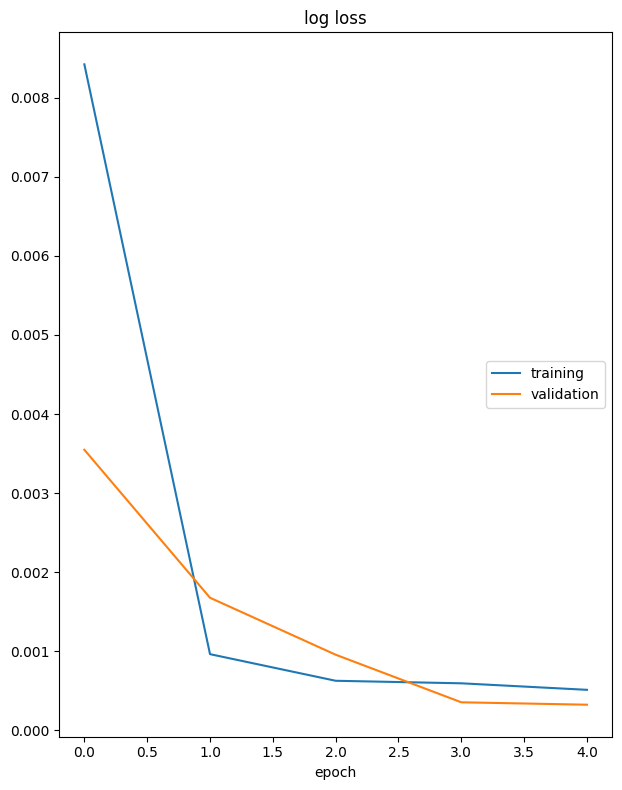

log loss
	training         	 (min:    0.001, max:    0.008, cur:    0.001)
	validation       	 (min:    0.000, max:    0.004, cur:    0.000)


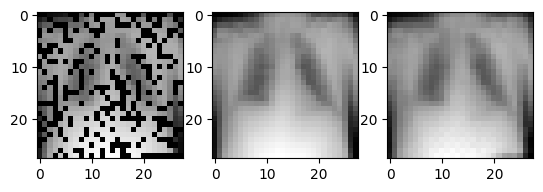

In [15]:
liveloss = PlotLosses()
for i in range(nepochs):
    train_loss = train(model, optimiser, mseloss, train_loader)
    valid_loss = valid(model, mseloss, valid_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

    # Visualise a random validation sample
    valid_sample, valid_target = valid_dataset[torch.randint(0, len(valid_dataset), (1,)).item()]
    output_sample = model(valid_sample.unsqueeze(0).to(device))
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(valid_sample[0].cpu(), cmap="gray")
    axs[1].imshow(valid_target[0].cpu(), cmap="gray")
    axs[2].imshow(output_sample[0, 0].detach().cpu(), cmap="gray")
    plt.show()

Let's try to save and then reload our model:

In [17]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [19]:
!mkdir '/content/drive/My Drive/models'  # create the director for storing the model in Google Drive

model_save_name = 'chestmnist_UNet_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/drive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage
torch.save(model.state_dict(), path)

model.load_state_dict(torch.load(path)) # loads the parameters of the model in path. state_dict is a dictionary object that maps each layer in the model to its trainable parameters (weights and biases).


mkdir: cannot create directory ‘/content/drive/My Drive/models’: File exists


<All keys matched successfully>

### **1.8. Run the test loop**

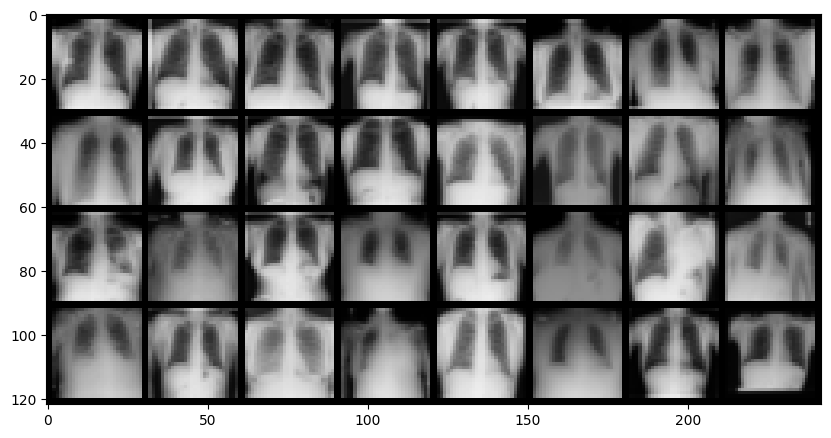

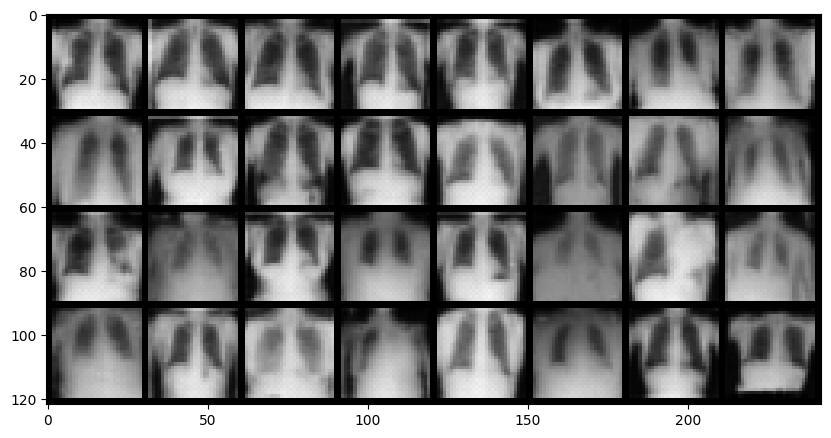

In [20]:
target, output = test(model, test_loader)
target, output = target[:32], output[:32]

target_grid = make_grid(target)
output_grid = make_grid(output)

plt.figure(figsize=(10,10))
plt.imshow(target_grid.detach().cpu().permute(1,2,0))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(output_grid.detach().cpu().permute(1,2,0))
plt.show()